# Langtjern data processing for the PROGNOS project

## Required python libraries and files, setup variables

In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = raw_input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig
    

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)        

Using python version:
2.7.12 (default, Nov 20 2017, 18:23:56) 
[GCC 5.4.0 20160609]
Paths to python libraries:
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/local/lib/python2.7/dist-packages/pyandoc-0.0.1-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/numpy-1.8.0-py2.7-linux-x86_64.egg', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/python2.7/dist-packages/wx-3.0-gtk2', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/jose-luis/.ipython']


###### Setting up dates to fetch

In [2]:
#Setting up date to load data

#fromDate = "2015/08/20"  #Please don't change the format
#toDate = "2015/09/15"

#fromDate = "2014/01/01"
#toDate = "2015/12/31"

fromDate = "2014/01/01"
toDate = "2014/12/31"

#fromDate = "2014/10/05"
#toDate = "2014/10/25"

#fromDate = "2015/04/05"
#toDate = "2015/04/25"

#fromDate = "2013/08/13"
#toDate = "2016/08/13"

#fromDate = "2015/01/01"
#toDate = "2016/08/01"

###### Asking for credentials to AquaMonitor.

In [3]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG] 
Password: ········


## Loading Langtjern data using urllib2

For details, please se the "AquaMonitor.py" and "LangtjernWeather.py" that interact with AquaMonitor (and the underlying database) using urllib2. Please note that the Python 2 kernel is required to run this code.

**Please note**: The time in AquaMonitor is given in UTC and should be changed to Norwegian Standard time


In [4]:
allData = lw.getLangtjernData(username,password,root,fromDate,toDate)
del password
#Changing timestamp to Norwegian Standard Time
print("The data that were read are: ")
for dummy,i in allData.iteritems() :
    i.index = i.index + pd.DateOffset(hours=1)
    print (i.columns)

The data that were read are: 
Index([u'Depth1', u'Depth2', u'CDOM_µg/L', u'Temperatur_C', u'Vannstand_m'], dtype='object')
Index([u'Globalstråling_W/m2', u'Lufttemperatur_°C ', u'Nedbør_mm',
       u'Relativ luftfuktighet_%', u'Vindhastighet_m/s',
       u'Vindhastighet (maks)_m/s', u'Vindretning_°'],
      dtype='object')
Index([u'Depth1', u'Depth2', u'O2 (metning)_%', u'Temperatur_C'], dtype='object')
Index([u'Depth1', u'Depth2', u'CDOM_µg/L', u'Konduktivitet_mS/m', u'pH',
       u'Temperatur_C', u'Vannstand_m'],
      dtype='object')


### Getting missing atmospheric pressure data from nearest station

Since atmospheric pressure is not measured at Langtjern, data from the nearest Meteorologisk Institutt (metno) stations measuring it will be used. This also applies to cloud cover.

The metno data is downloaded using the following notebooks:

* [Catchment delineation](https://nbviewer.jupyter.org/github/Lecheps/Catchment_delineation/blob/master/Catchment_delineation.ipynb)
* [Data download from metno](https://nbviewer.jupyter.org/github/Lecheps/Catchment_delineation/blob/master/metno_download.ipynb)

The atmospheric pressure is formatted as a pandas dataframe, saved as a pickle and loaded here:

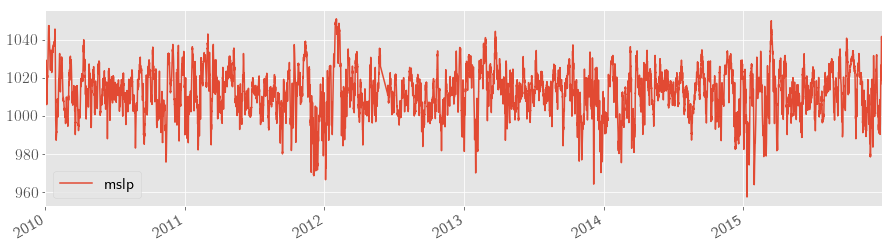

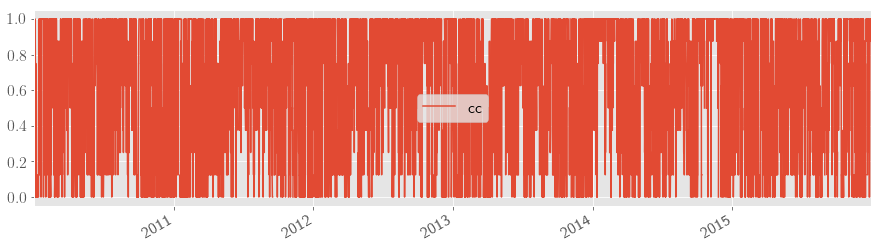

In [5]:
with open('/home/jose-luis/Documents/Python/PROGNOS/metnoData/data.pickle', 'rb') as handle:
    metnoData = pickle.load(handle)
pylab.rcParams['figure.figsize'] = (15, 4)    
#print(metnoData)
mslp = metnoData[0]
mslp.columns=['mslp']
mslp.plot()
cc = metnoData[1]
cc.columns=['cc']
cc[cc['cc'] == - 3] = np.nan
cc.iloc[:,0] /= 8
cc.plot()

## Saving meteo data

* u10: east-west wind speed m/s
* v10: north south wind speed m/s
* mslp: mean sea level pressure bar ->using data from nearby station
* t2: temperature degree Celsius
* hum: Relative humidity %
* cc: cloud cover -> using data from nearby station

The results will be saved in *Langtjern\_weather.dat*


The type of GOTM_weater is <class 'pandas.core.frame.DataFrame'>


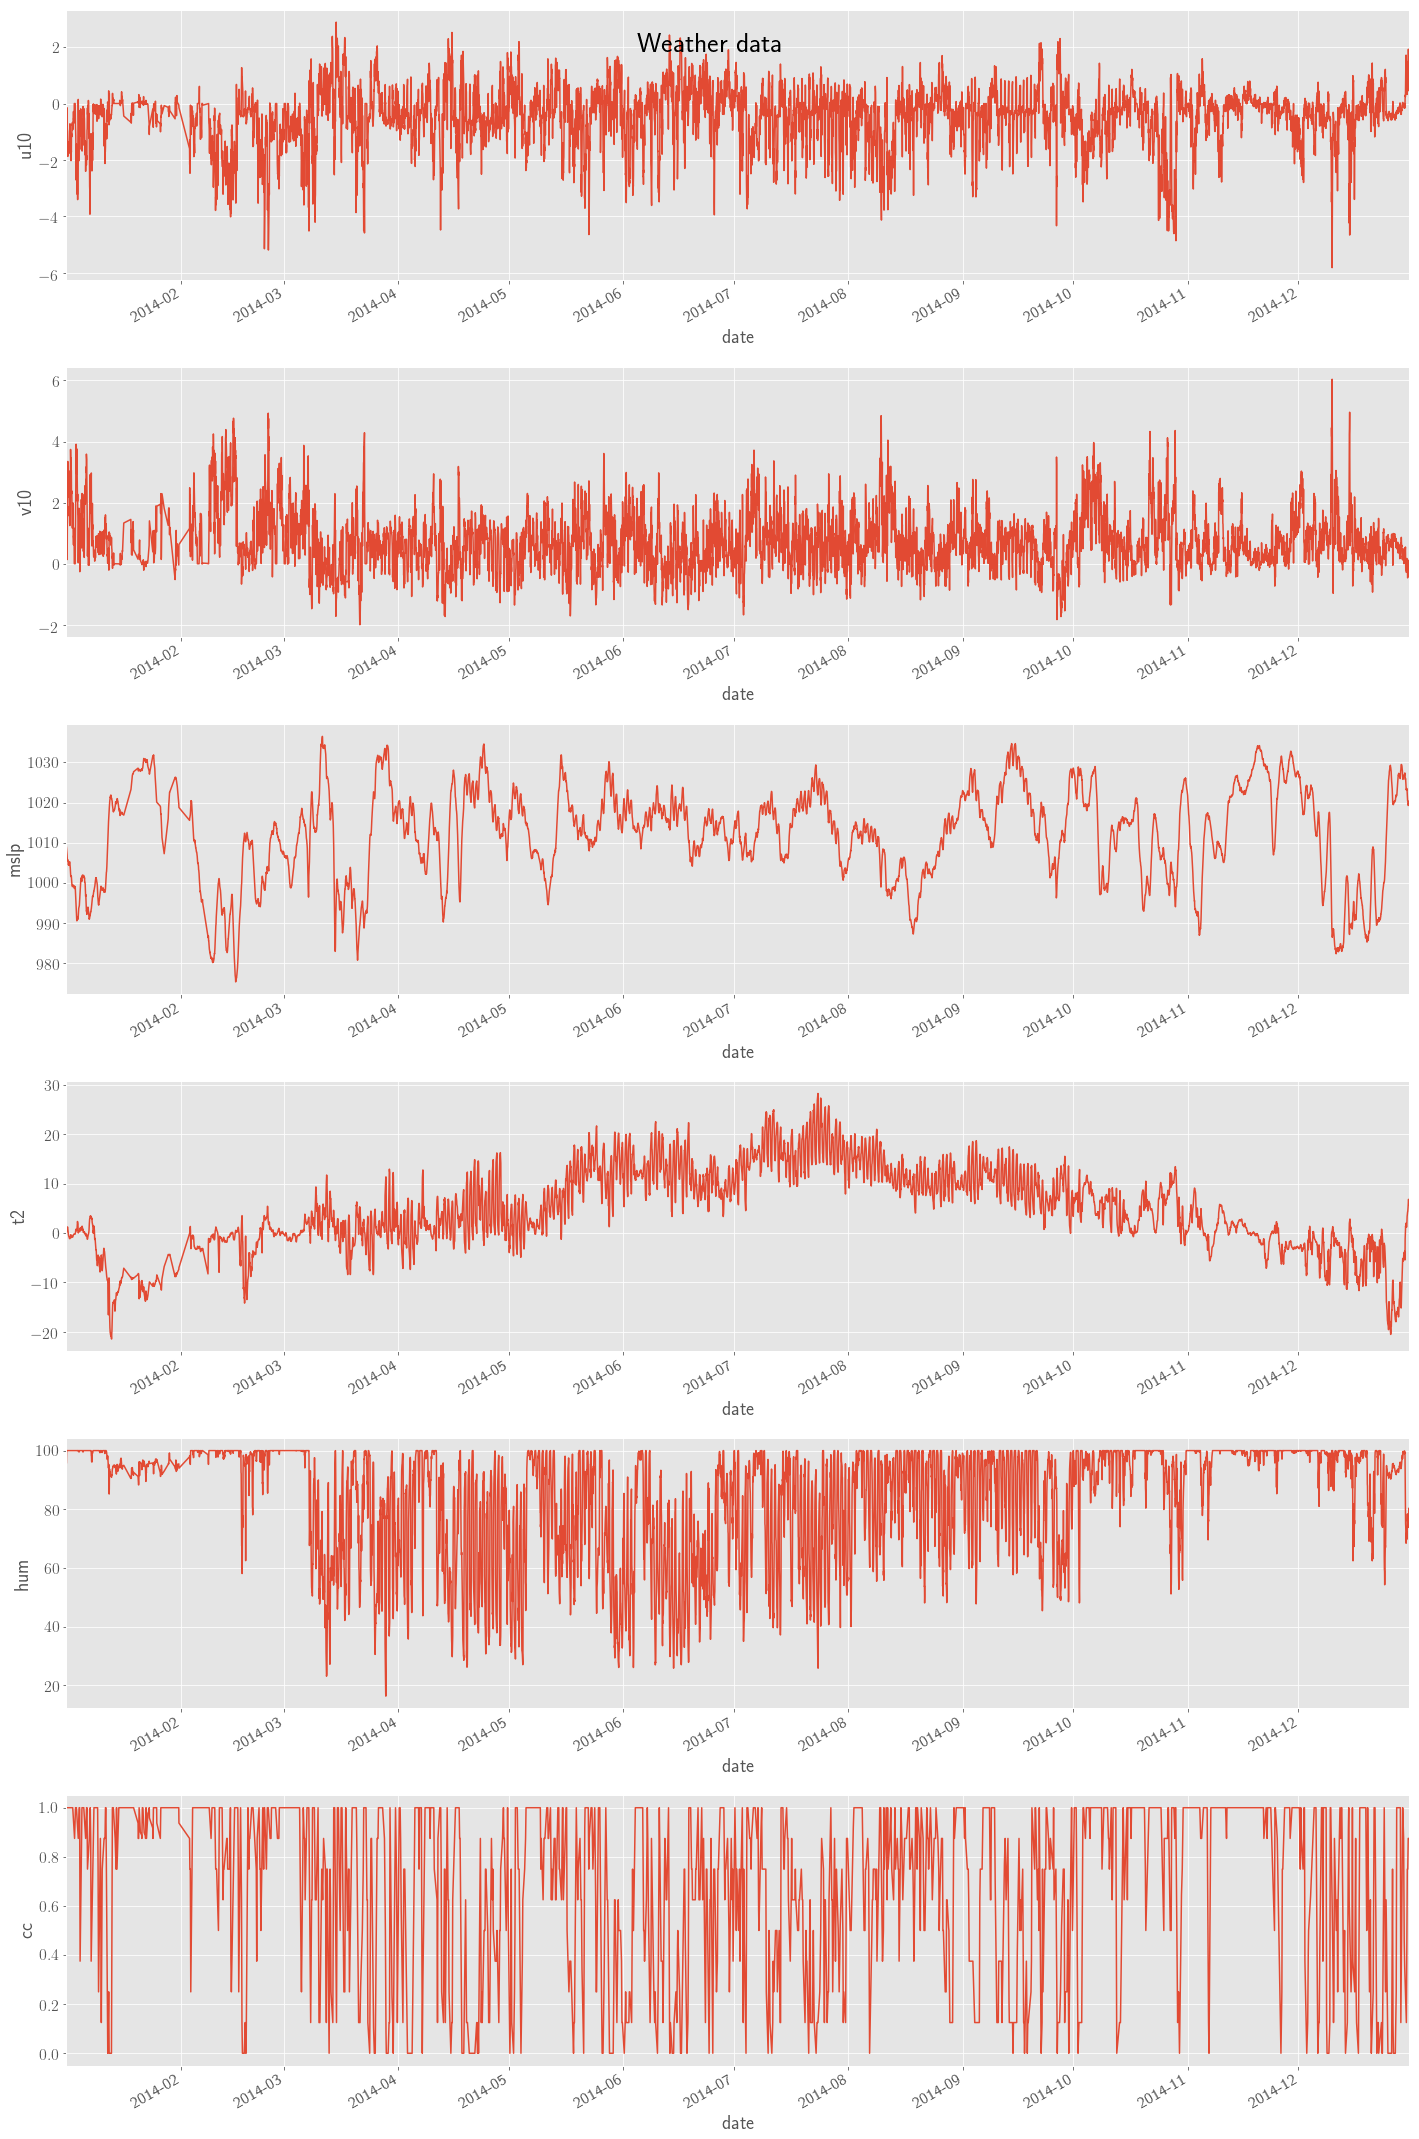

In [6]:
#Saving the meteo data
GOTM_weather = allData['weather'].iloc[:,[4,4,6,1,3,0]]
GOTM_weather.index.name = '#date'
bla = 1013.0
blabla = 0.6
GOTM_weather.columns = ['u10', 'v10', 'mslp', 't2', 'hum', 'cc'] #Temporarily storing wind direction in mslp
GOTM_weather.loc[:,'u10'] = GOTM_weather.loc[:,'u10'] * np.cos(np.deg2rad(GOTM_weather.loc[:,'mslp']))
GOTM_weather.loc[:,'v10'] = GOTM_weather.loc[:,'v10'] * np.sin(np.deg2rad(GOTM_weather.loc[:,'mslp']))
GOTM_weather.loc[:,'mslp'] = np.nan
GOTM_weather.loc[:,'cc'] = np.nan
GOTM_weather.update(cc)
GOTM_weather.update(mslp)
GOTM_weather.interpolate(inplace=True) #Linear interpolation of missing values and NaN's

#Plotting variables
fig = plot_df(GOTM_weather)

#Setting up GOTM formatting for saving as a .dat file
GOTM_weather.loc[:,'mslp'] = GOTM_weather['mslp'].map(lambda x : '%0.2f' % x)
GOTM_weather.loc[:,'hum'] = GOTM_weather['hum'].map(lambda x : '%0.2f' % x)
GOTM_weather.loc[:,'cc'] = GOTM_weather['cc'].map(lambda x : '%0.3f' % x)

print("The type of GOTM_weater is %s" % type(GOTM_weather))
#Saving    
GOTM_weather.to_csv(result_dir + 'langtjern-weather.dat',\
                    sep = "\t",float_format='%0.2f',\
                    date_format = '%Y-%m-%d %H:%M:%S')

fig.suptitle('Weather data', size = 'xx-large')
fig.tight_layout()

## Saving inlet data

Discharge is obtained from stage with the use of the following rating curve:

 $ \textrm{if } gh > 0.345 \textrm{ then }  q = 2.391 \times (gh - 0.345)^{2.5} \textrm{ else } q = 0.0001 $
 
 $q(m^3/s) \textrm { and } gh(m) $
 
**Please note** In the info received from NVE the value for the multiplier was 2391, which unlikely large discharge. This was changed to 2.391
 
**Please note** The inlet just covers a portion of the catchment and will be scaled by area in order to be representative of the entire catchment. This is a kludge.

CDOM data prior to 2012 are highly uncertain. It is recommended not to use them.
 
 Two data files will be saved:
 
 * CDOM data in $\mu g/l$
 * Discharge and water temperature in $m^3/s$ and $^\circ C$ respectively 
 
 
 

The average discharge is: 
0.126046755589


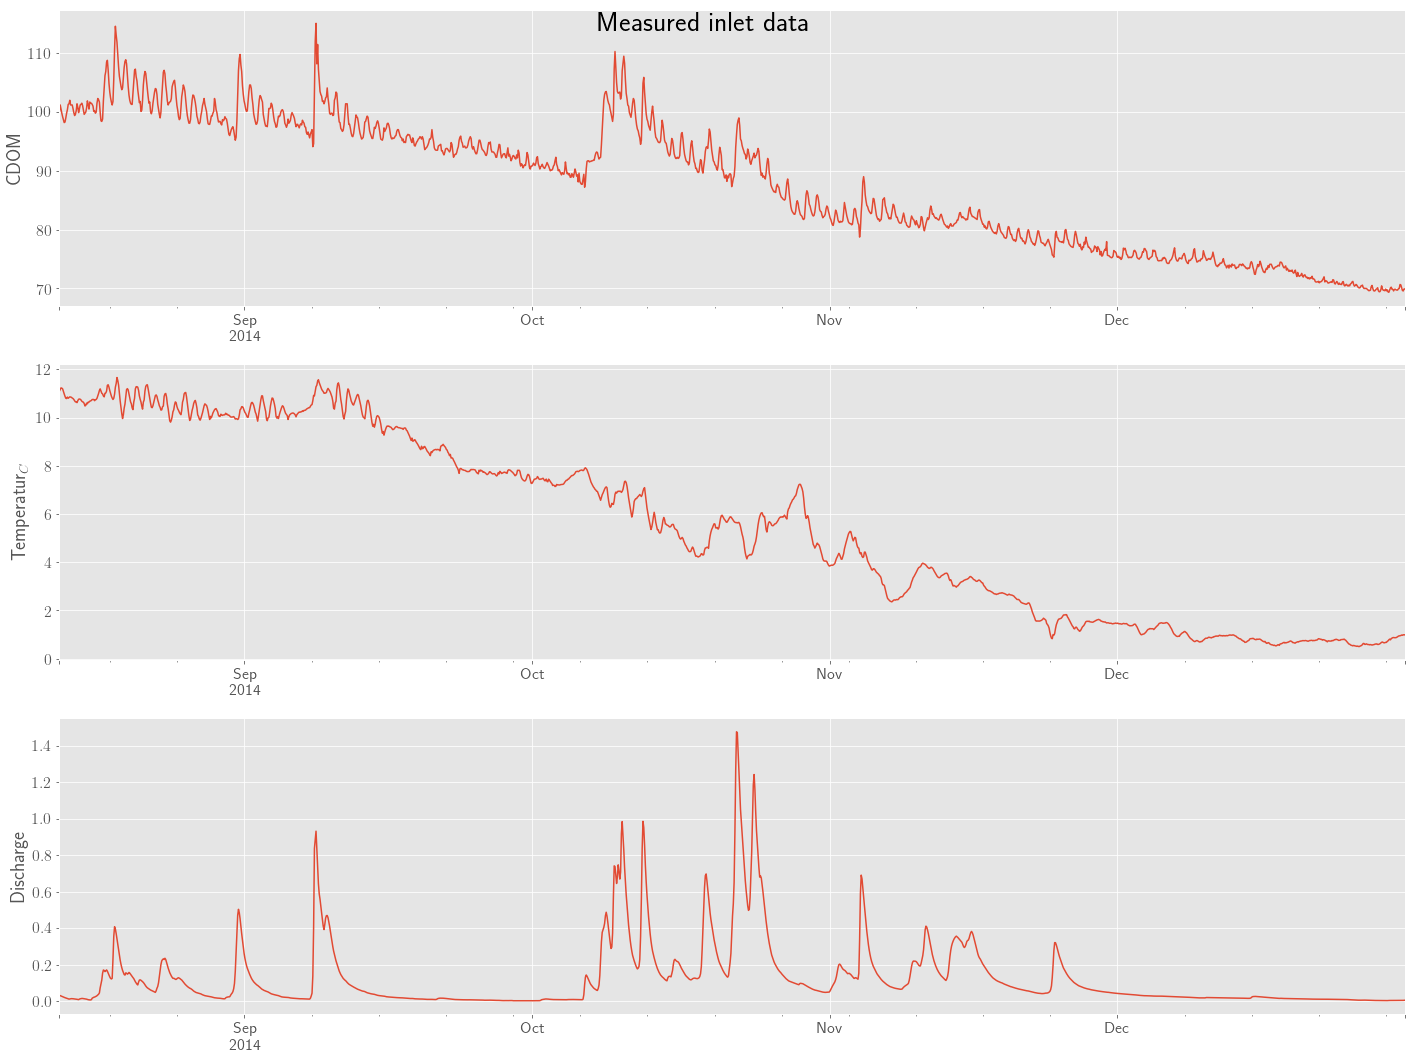

In [7]:
#Filling in missing values and nans from inlet data using linear interpolation
allData['inlet'].interpolate(inplace=True)

#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
o2FromT = lambda x : x * 2
allData['inlet'] = allData['inlet'].rename(columns={'Vannstand_m':'Discharge',u'CDOM_µg/L' : 'CDOM'})
allData['inlet'].loc[:,'Discharge'] = allData['inlet'].loc[:,'Discharge'].apply(inletQ)
allData['inlet'].loc[:,'Discharge'] = allData['inlet'].loc[:,'Discharge'] * (4.8 + 0.23) / 0.8
#allData['inlet']['O2'] = allData['inlet']['Temperatur_C'].map(o2FromT)
#df['Col3'] = df['Col2'].map(lambda x: 42 if x > 1 else 55)
#allData['inlet'].loc[:,'O2'] = allData['inlet'].loc[:,'O2'].apply(o2FromT)

print("The average discharge is: ")
print (np.mean(allData['inlet'].loc[:,'Discharge']))

#Visualizing data
fig = plot_df(allData['inlet'].iloc[:,2:])

#Saving inlet data
fcdom = open(result_dir + 'langtjern-inlet-cdom-ug-per-l.dat','w')
fdisch = open(result_dir + 'langtjern-inlet-q.dat','w')
#Splitting cdom into doma and domb
fdoma =  open(result_dir + 'langtjern-inlet-doma-ug-per-l.dat','w')
fdomb =  open(result_dir + 'langtjern-inlet-domb-ug-per-l.dat','w')


for i,j in allData['inlet'].iterrows() :
    fcdom.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')
    fdoma.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')
    fdomb.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')
    fdisch.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' \
                 + str(j.loc['Discharge']) + ' ' + str(j.loc['Temperatur_C']) + '\n') 

fcdom.close()
fdisch.close()

fig.suptitle('Measured inlet data', size = 'xx-large')
fig.tight_layout()

## Saving outlet data

Discharge is obtained from the stage using the following rating curve:

 $ \textrm{if } gh > 0.37 \textrm{ then }  q = 3.2136 \times gh^{2.453} \textrm{ else } q = 3.794 \times gh^{2.692}$
 
$q(m^3/s) \textrm { and } gh(m) $

**Please note** The gauge height is not directly measured at the flume but at some upstream point and the gauge height should be corrected by a height (substraction) of *0.1403*

CDOM at the outlet must be corrected because of recalibration in 2012 $10\mu g/l$ should be added to all values before _22/11/2012_ NO time.

Additionaly with respect to the inlet, the conductivity is measured here as well.

Three data files will be saved:
* CDOM data in  μg/l 
* Discharge and water temperature in  m3/s  and  ∘C respectively
* Conductivity in mS/m

The average discharge is: 
0.536302735806


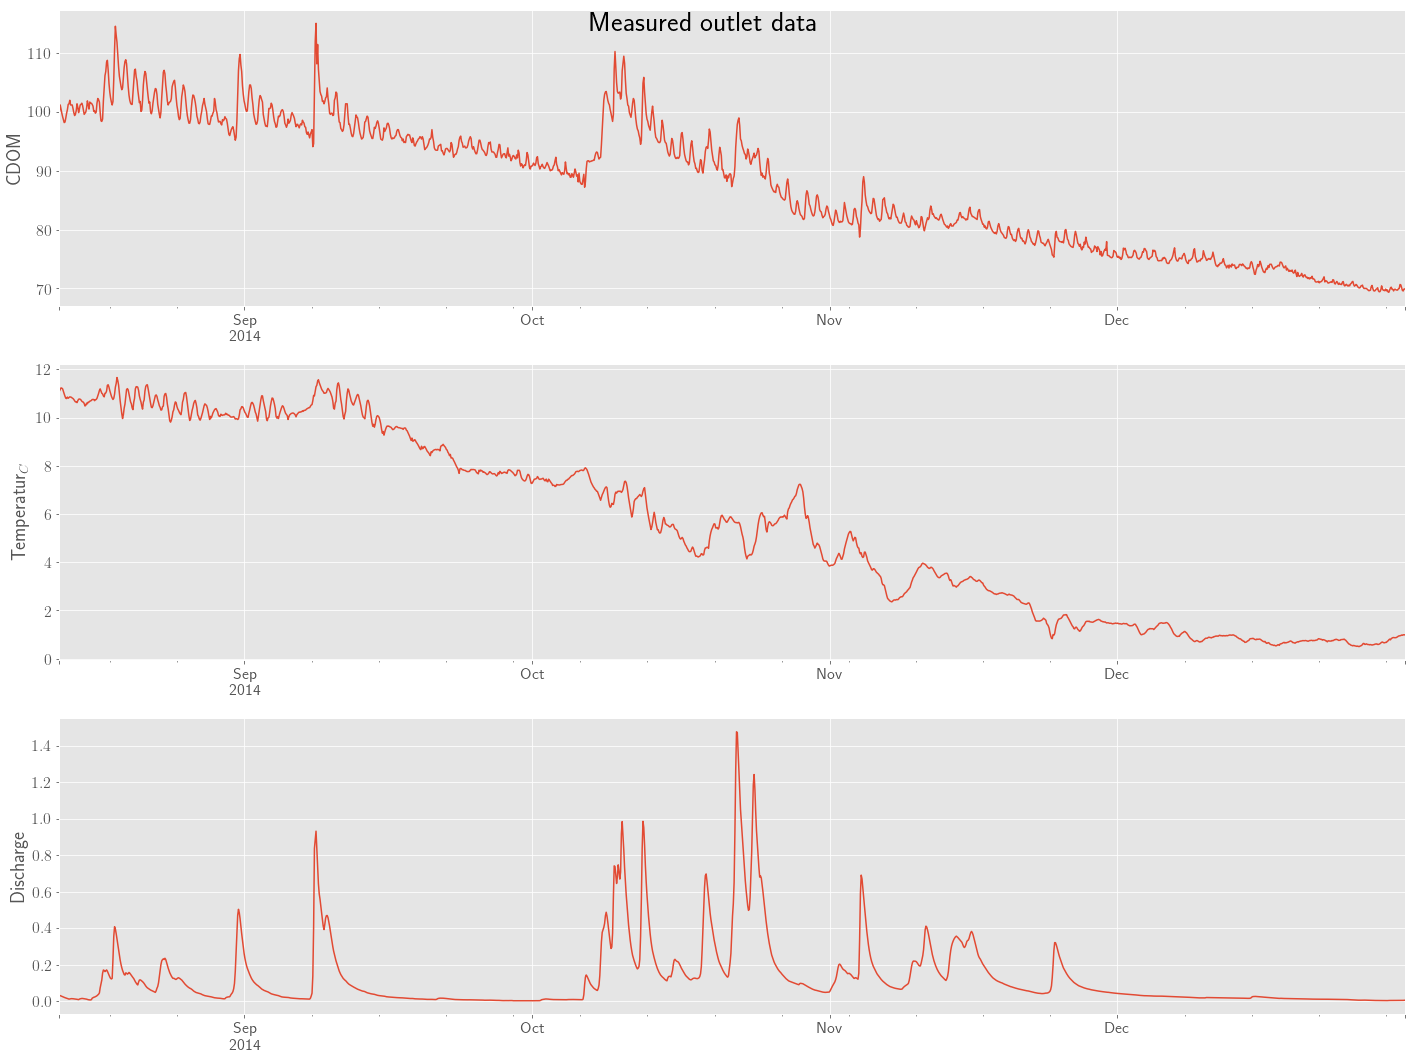

In [8]:
#Filling in missing values and nans from inlet data using linear interpolation
allData['outlet'].interpolate(inplace=True) 

#Transforming stage into discharge
outletQ = lambda x : 3.2136 * np.power(x - 0.1403, 2.453) if x > 0.37 else 3.794 * np.power(x - 0.1403, 2.692)  

allData['outlet'] = allData['outlet'].rename(columns={'Vannstand_m':'Discharge',u'CDOM_µg/L' : 'CDOM'})
allData['outlet'].loc[:,'Discharge'].apply(outletQ)

print("The average discharge is: ")
print (np.mean(allData['outlet'].loc[:,'Discharge']))

#Visualizing data
fig = plot_df(allData['inlet'].iloc[:,2:])

#Saving outlet data
fcdom =  open(result_dir + 'langtjern-outlet-cdom-ug-per-l.dat','w')
fdisch = open(result_dir + 'langtjern-outlet-q.dat','w')
fcond =  open(result_dir + 'langtjern-outlet-cond-us-per-m.dat','w')
fcdom_obs = open(result_dir + 'langtjern_cdom_out.obs', 'w')


#fpH = open('langtjern-outlet_ph.dat','w')

for i,j in allData['outlet'].iterrows() :
    fcdom.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc[u'CDOM']) + '\n')
    fcdom_obs.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' -0.0 ' + str(j.loc[u'CDOM']) + '\n')
    fdisch.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' -' \
                 + str(j.loc['Discharge']) + ' ' + str(j.loc['Temperatur_C']) + '\n')
    fcond.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' \
                 + str(j.loc['Konduktivitet_mS/m']) + '\n')
    
   # fpH.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['pH']) + '\n')
fcdom.close()
fdisch.close()

fig.suptitle('Measured outlet data', size = 'xx-large')
fig.tight_layout()

## Saving profile data

GOTM will fill in the missing values in the profile data. Therefore only the depths at which there actually are measurements are included here.

Two profiles will be saved:

* One for temperature in $^{\circ}C$
* One for $O_2$ in _%_

In [9]:
#Storing profile data in an array for visualization
t = []
O2 = []
O2_y = []

#Getting indexes to unique dates (each date a profile)
idx_list = {}
idx_list[allData['lake'].index[0]] = [0]
cnt = 0
for i in allData['lake'].index[1:]:
    if i == allData['lake'].index[cnt]:
        idx_list[i].append(cnt+1)
    else :
        idx_list[i] = [cnt+1]   
    cnt = cnt + 1

#Finding unique depths
unik_depth_O2 = sorted(list(allData['lake'].loc[:,'Depth1'].unique()))
unik_depth_t = sorted(list(allData['lake'].loc[:,'Depth2'].unique()))
ind_O2_dict = dict((k,i) for i,k in enumerate(unik_depth_O2))
ind_t_dict = dict((k,i) for i,k in enumerate(unik_depth_t))

isvalid_O2_and_t = np.logical_not(np.isnan(allData['lake'].iloc[:,2:4]).as_matrix())
  
#Preallocating arrays to store O2 and temperature data
O2 = np.zeros((len(idx_list),len(unik_depth_O2)))
O2[:] = np.NaN
t = np.zeros((len(idx_list),len(unik_depth_t)))
t[:] = np.NaN
#date_x = np.zeros(len(idx_list),dtype='datetime64[s]')
date_x = list(allData['lake'].index.unique())

#Filling up O2 and t arrays
cnt = 0;
for key,val in sorted(idx_list.iteritems()):
    is_data_O2 = isvalid_O2_and_t[val,0]
    is_data_t = isvalid_O2_and_t[val,1]
    date_x[cnt] = (allData['lake'].index[val[0]])
    val_O2 = allData['lake'].iloc[list(compress(val,is_data_O2)),[0,2]]
    val_t =  allData['lake'].iloc[list(compress(val,is_data_t)),[1,3]]
    dict_O2 = dict(zip(val_O2.iloc[:,0],val_O2.iloc[:,1])) 
    dict_t = dict(zip(val_t.iloc[:,0],val_t.iloc[:,1]))
    for key_,val_ in dict_O2.iteritems() :
        O2[cnt,ind_O2_dict[key_]] = val_
    for key_,val_ in dict_t.iteritems() :
        t[cnt,ind_t_dict[key_]] = val_  
    cnt += 1

O2 = np.transpose(O2)
t = np.transpose(t)

#O2 = O2/100;
#Transforming temperature saturation percentage to concentration in mmol/m3
O2 = O2/100 * 1e3 * (14.59 - 0.3955*t + 0.0072*t*t - 0.0000619*t*t*t) / (31.9988)

print(O2)
    
print('Done!' )

[[          nan           nan           nan ...,           nan
            nan           nan]
 [ 204.03044101  208.55117009  208.83686365 ...,  262.30183873
   259.12043686  249.20810922]
 [          nan           nan           nan ...,           nan
            nan           nan]
 ..., 
 [          nan           nan           nan ...,           nan
            nan           nan]
 [          nan           nan           nan ...,           nan
            nan           nan]
 [ 157.31431981  154.73874337  155.42735296 ...,  125.52024583
   122.26431517  121.0665982 ]]
Done!


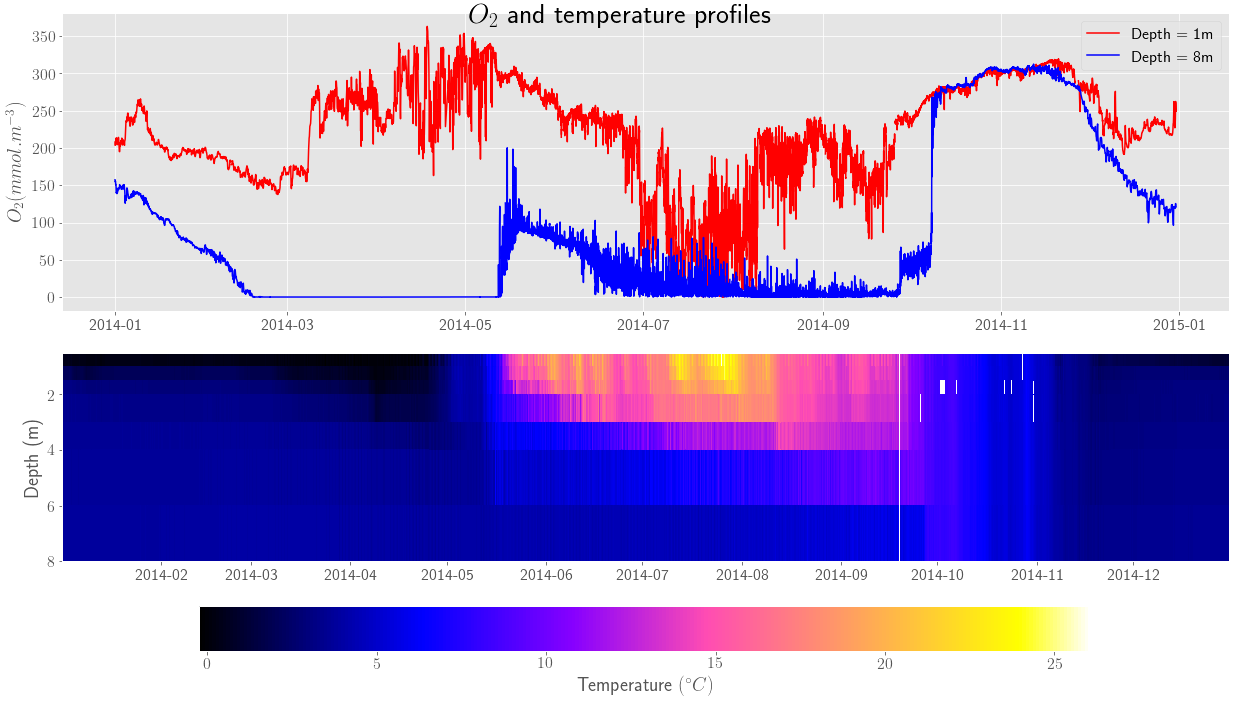

In [10]:
#Visualizationfig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (17.5, 10))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (17.5, 10))

ma = np.ma.array(O2, mask=np.isnan(O2))
cmap = matplotlib.cm.gist_heat_r #jet #afmhot_r
cmap.set_bad('white',1.)
axes[0].plot(date_x,O2[1,:],'r-',label = "Depth = 1m")
axes[0].plot(date_x,O2[7,:],'b-',label = "Depth = 8m")
axes[0].legend()
axes[0].set_ylabel(r'$O_{2} (mmol.m^{-3})$')

t_y = np.r_[unik_depth_t, unik_depth_t[-1]]
t_x = date_x
t_x.append(date_x[-1] + datetime.timedelta(hours=1.5))
mat = np.ma.array(t, mask=np.isnan(t))
cmap = matplotlib.cm.gnuplot2 #afmhot_r
cmap.set_bad('white',1.)
im = axes[1].pcolormesh(t_x, t_y, mat, cmap = cmap)
axes[1].set_ylabel('Depth (m)')

axes[1].invert_yaxis()
plt.colorbar(im, orientation='horizontal', ax = axes[1], label =r'Temperature $\left(^{\circ}C\right)$')

fig.suptitle('$O_2$ and temperature profiles', size = 'xx-large')
fig.tight_layout()



In [11]:
#Saving the temperature and oxygen profiles in gotm format. Saving only depth and timesteps for which data exist.

to_string_date = lambda date,num_depths : datetime.datetime.strftime(date,'%Y-%m-%d %H:%M:%S') + \
                                      ' ' + str(num_depths) + ' ' + str(2) + '\n'
to_string_values = lambda depth,val : '-' + str(depth) + ' ' + str(val) + '\n'

to_string_values_acpy = lambda t,depth,val :  datetime.datetime.strftime(t,'%Y-%m-%d %H:%M:%S') + '\t' + \
                                              '-' + str(depth) + '\t' + str(val) + '\n'
#Saving data in GOTM/FABM format
def saveProfile(filename,data,depth,date) :
    fid = open(filename,'w')
    for col, t in IT.izip(data.T,date) :
        num_val = sum(np.logical_not(np.isnan(col)))
        if num_val > 0 :
            fid.write(to_string_date(t,num_val))
            idx = np.where(np.logical_not(np.isnan(col)))
            for dummy,i in enumerate(idx) :
                for dummy, ii in enumerate(i) :
                    fid.write(to_string_values(depth[ii],col[ii]))
    fid.close
    
#Saving data in ACPY format
def saveProfileACPY(filename,data,depth,date) :
    fid = open(filename,'w')
    for col, t in IT.izip(data.T,date) :
        num_val = sum(np.logical_not(np.isnan(col)))
        if num_val > 0 :
            idx = np.where(np.logical_not(np.isnan(col)))
            for dummy,i in enumerate(idx) :
                for dummy,ii in enumerate(i) :
                    fid.write(to_string_values_acpy(t,depth[ii],col[ii]))
    fid.close
            
saveProfile(result_dir + 'langtjern-lake-O2-concentration_mmol_m3.dat',O2,unik_depth_O2,date_x)
saveProfile(result_dir + 'langtjern-temp-lake.dat',t,unik_depth_t,date_x)

saveProfileACPY(result_dir + 'temp.obs', t, unik_depth_t,date_x)

## Saving chemistry data provided by Leah

The data are located in *"\./Leah\_data/"*

In [12]:
basefolder = './Leah_data/'

#Loading the data in the format provided by Leah
input_outlet = pd.read_csv(basefolder + 'Ltj_MyLakeInput_Outlet.txt', sep = '\t', engine = 'python')
input_basin = pd.read_csv(basefolder + 'Ltj_MyLakeInput_S_basin.txt', sep = '\t', engine = 'python')

def keepFloat(df) : #This eliminates columns containing only zero
    df.set_index(pd.to_datetime(df.iloc[:,0:3]),inplace=True)
    df = df.loc[:,df.dtypes == 'float64']
    return df

input_outlet = keepFloat(input_outlet) 
input_basin = keepFloat(input_basin)

input_outlet.rename(columns = lambda x : re.sub('Outflow', '', x), inplace = 'True')
input_basin.rename(columns = lambda x : re.sub('Inflow', '', x), inplace = 'True')

#Saving data with the GOTM format
def saveVar(df,descriptor,isOut) :
    for name in df.columns :
        fid = open(result_dir + 'langtjern_' + descriptor + '_' + name + '.dat', 'w')
        for i,j in df[name].iteritems() :
            if isOut and name == 'Q' :
                to_save =  datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + \
                ' -' + str(j) + '\n'
            else :
                to_save =  datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + \
                ' ' + str(j) + '\n'
            fid.write(to_save)
        fid.close()
                    
#Saving the same period as the AquaMonitor data   
dtStart = datetime.datetime.strptime(fromDate + " 00:00:00", '%Y/%m/%d %H:%M:%S')
dtEnd = datetime.datetime.strptime(toDate + " 23:59:59", '%Y/%m/%d %H:%M:%S')         

saveVar(input_outlet.loc[(input_outlet.index>=dtStart) & (input_outlet.index<=dtEnd)]*1000,'outflow',True)
saveVar(input_basin.loc[(input_basin.index>=dtStart) & (input_basin.index<=dtEnd)]*1000,'inflow',False)

### Visualizing data

#### Outlet

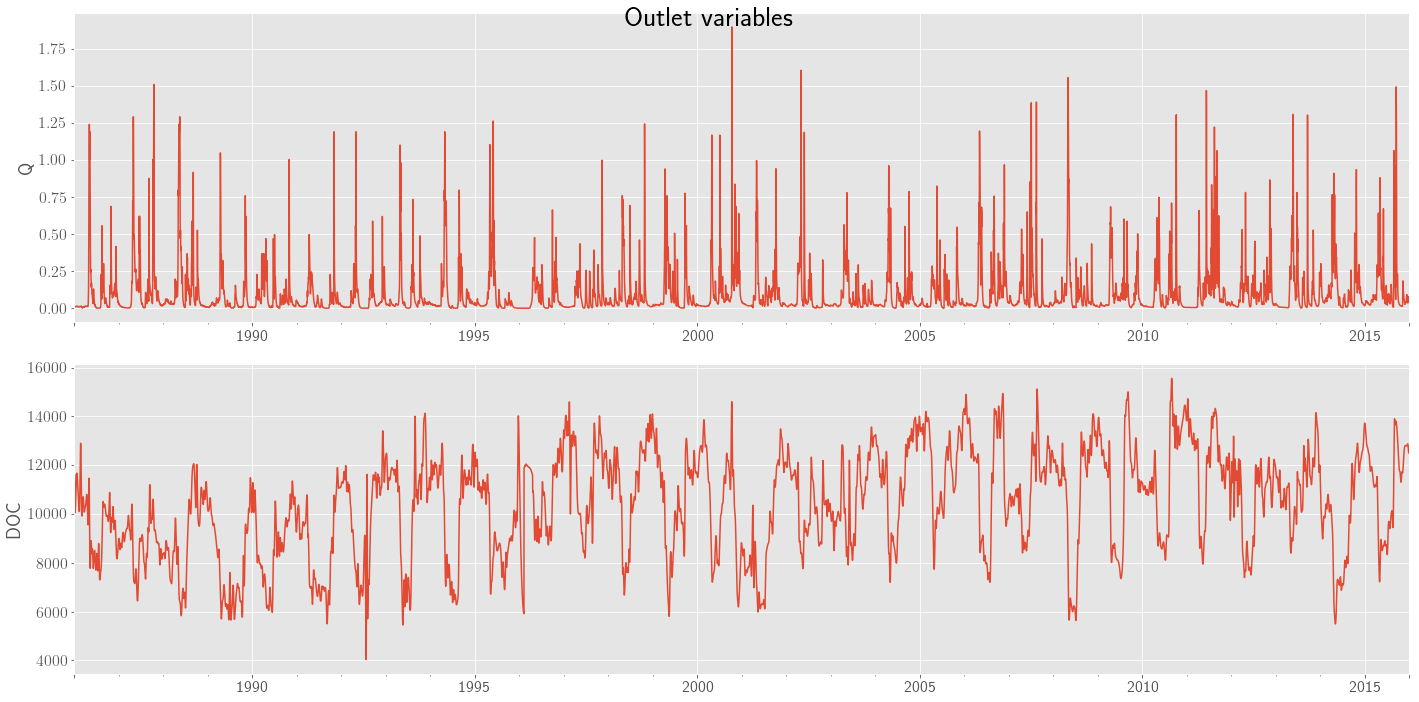

In [13]:
fig = plot_df(input_outlet)
fig.suptitle('Outlet variables', size = 'xx-large')
fig.tight_layout()

#### Basin input

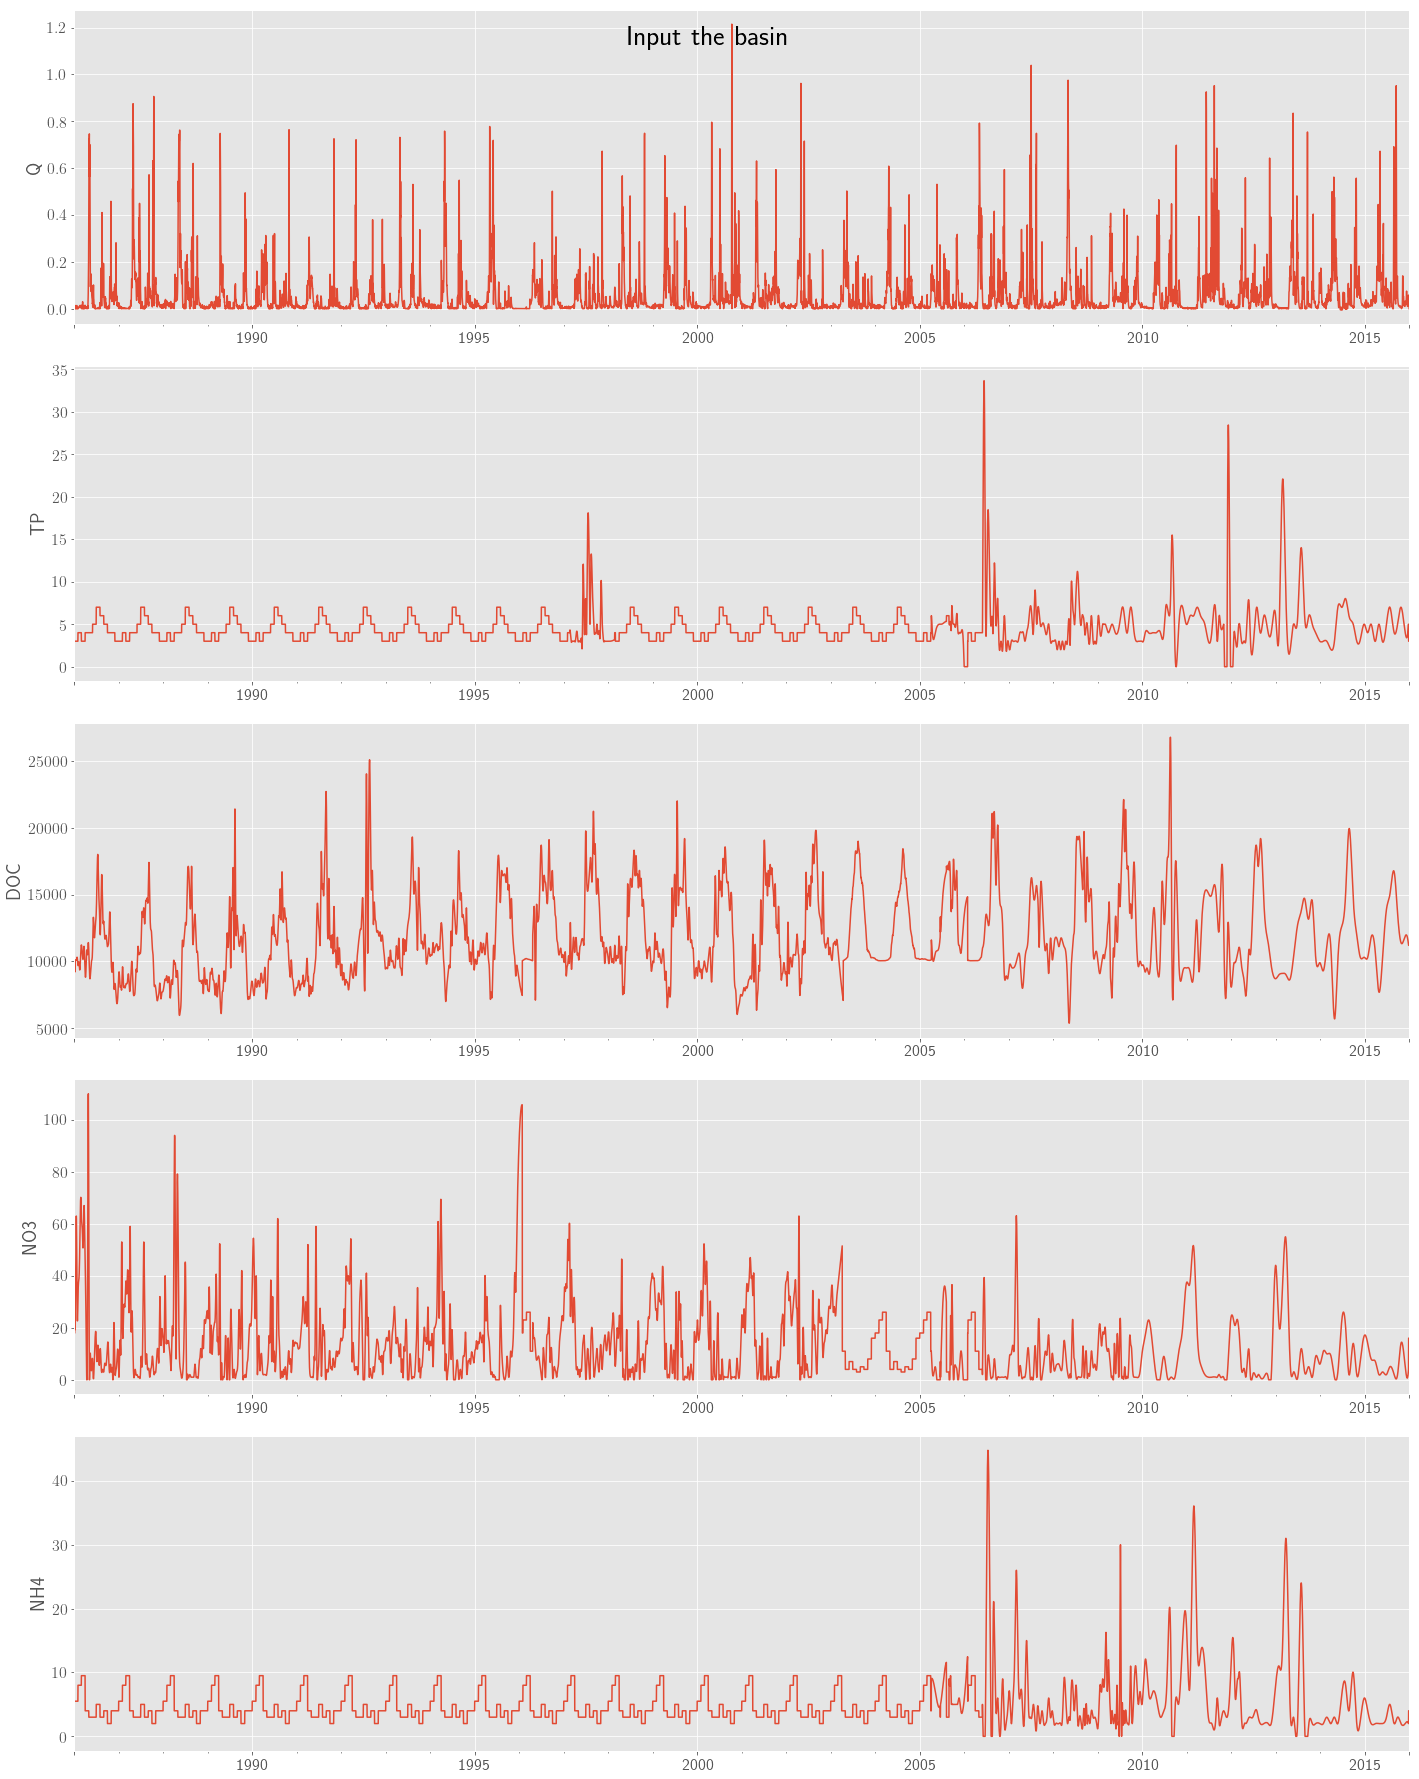

In [14]:
fig = plot_df(input_basin)
fig.suptitle('Input the basin', size = 'xx-large')
fig.tight_layout()

## General remarks

***Please note*** The discharge is highly uncertain. The rating curves need verification. I scaled the inlet discharge by area in order to be representative of the whole basin. Even with the scaling, the outlet discharge is much higher than the inlet on average. Unless the lake is drying out, this is not right.

***Please note*** Linear interpolation is performed on the missing data except for the temperature and oxygen profiles in the lake

***Please note*** Besides the corrections to CDOM suggested by Kari, no quality control has been performed here and just the raw data from AquaMonitor is presented here.

***Please note*** Both the cloud cover and the mean sea level pressure data are lacking from the weather forcings. Placeholders are being used.